<a href="https://colab.research.google.com/github/merazAfridi/Applying-Multiple-CNNs_Pediatric-Pneumonia-Classification/blob/main/1.%20VGG19_Pediatric_Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person1650_virus_2852.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person22_virus_55.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person122_bacteria_582.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person85_bacteria_417.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person79_virus_148.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person29_virus_64.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person123_bacteria_587.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person75_virus_136.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person153_bacteria_725.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person173_bacteria_831.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person16_virus_47.jpeg
/kaggle/input/pediatric-pneumonia/test/PNEUMONIA/person138_bacteria_659.jpeg
/kaggle/input/pediatric-p

In [ ]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Image Dimensions and Batch Size
img_height, img_width = 128, 128
batch_size = 32


In [ ]:
#Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [ ]:
#Load Training Data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/pediatric-pneumonia/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)


Found 4187 images belonging to 2 classes.


In [ ]:
#Load Validation Data
validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/pediatric-pneumonia/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 1045 images belonging to 2 classes.


In [ ]:
# Step 6: Load Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No augmentation for test data

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/pediatric-pneumonia/test/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 624 images belonging to 2 classes.


In [ ]:
#Print Shapes and Sizes of Datasets
print(f'Train Data: {train_generator.n} images')
print(f'Validation Data: {validation_generator.n} images')
print(f'Test Data: {test_generator.n} images')


Train Data: 4187 images
Validation Data: 1045 images
Test Data: 624 images


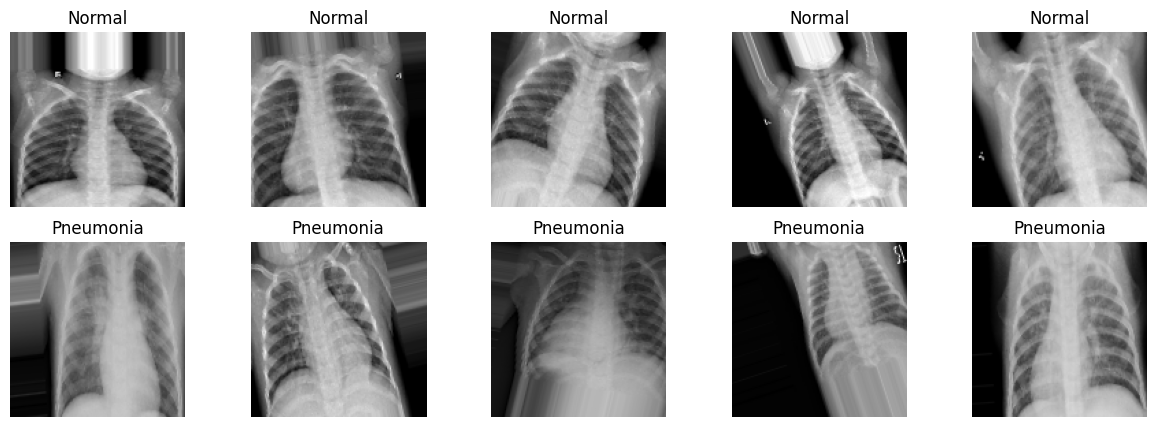

In [ ]:
# Display First 5 Normal and Pneumonia Training Samples
def display_samples(generator, num_samples=5):
    plt.figure(figsize=(15, 5))
    normal_count = 0
    pneumonia_count = 0

    for x_batch, y_batch in generator:
        for i in range(len(y_batch)):
            if y_batch[i] == 0 and normal_count < num_samples:
                plt.subplot(2, num_samples, normal_count + 1)
                plt.imshow(x_batch[i])
                plt.title('Normal')
                plt.axis('off')
                normal_count += 1
            elif y_batch[i] == 1 and pneumonia_count < num_samples:
                plt.subplot(2, num_samples, num_samples + pneumonia_count + 1)
                plt.imshow(x_batch[i])
                plt.title('Pneumonia')
                plt.axis('off')
                pneumonia_count += 1

            if normal_count >= num_samples and pneumonia_count >= num_samples:
                break
        if normal_count >= num_samples and pneumonia_count >= num_samples:
            break

# Display
display_samples(train_generator)


In [ ]:
# Print Total Size and Shape of Datasets
print(f'Train Data Size: {train_generator.n} images')
print(f'Validation Data Size: {validation_generator.n} images')
print(f'Test Data Size: {test_generator.n} images')

x_train, y_train = next(train_generator)
x_val, y_val = next(validation_generator)
x_test, y_test = next(test_generator)

print(f'Train Data Shape: {x_train.shape} | Labels Shape: {y_train.shape}') #each batch
print(f'Validation Data Shape: {x_val.shape} | Labels Shape: {y_val.shape}')
print(f'Test Data Shape: {x_test.shape} | Labels Shape: {y_test.shape}')


Train Data Size: 4187 images
Validation Data Size: 1045 images
Test Data Size: 624 images
Train Data Shape: (32, 128, 128, 3) | Labels Shape: (32,)
Validation Data Shape: (32, 128, 128, 3) | Labels Shape: (32,)
Test Data Shape: (32, 128, 128, 3) | Labels Shape: (32,)


In [ ]:
#VGG19

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

#VGG19 with pretrained weights from ImageNet, excluding the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Display model summary
model.summary()



Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             

 Total params: 22,122,049 (84.39 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, AUC

# Instantiate metrics
precision_metric = Precision()
auc_metric = AUC()

# save model
checkpoint_filepath = '/kaggle/working/best_model_VGG19.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

#Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_metric, auc_metric])

# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 524ms/step - accuracy: 0.7652 - auc_15: 0.7546 - loss: 0.6932 - precision_17: 0.8262 - val_accuracy: 0.8711 - val_auc_15: 0.9529 - val_loss: 0.2893 - val_precision_17: 0.9772
Epoch 2/20
  1/130 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9688 - auc_15: 0.9896 - loss: 0.1803 - precision_17: 1.0000

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9688 - auc_15: 0.9896 - loss: 0.1803 - precision_17: 1.0000 - val_accuracy: 0.9048 - val_auc_15: 0.9375 - val_loss: 0.3557 - val_precision_17: 1.0000
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 68s 502ms/step - accuracy: 0.9010 - auc_15: 0.9531 - loss: 0.2419 - precision_17: 0.9256 - val_accuracy: 0.9072 - val_auc_15: 0.9699 - val_loss: 0.2106 - val_precision_17: 0.9537
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - auc_15: 0.9185 - loss: 0.2689 - precision_17: 0.9259 - val_accuracy: 0.8571 - val_auc_15: 0.9694 - val_loss: 0.2631 - val_precision_17: 0.9231
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 67s 496ms/step - accuracy: 0.9085 - auc_15: 0.9605 - loss: 0.2239 - precision_17: 0.9332 - val_accuracy: 0.9102 - val_auc_15: 0.9702 - val_loss: 0.2014 - val_precision_17: 0.9526
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - auc_15: 0.9885 - loss: 0.1288 - precision_17: 1.0000 - val_accuracy:

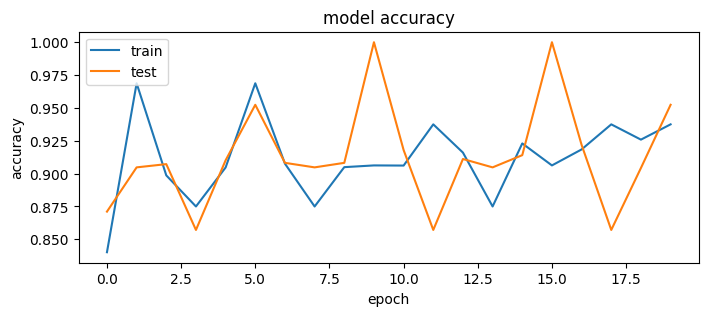

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(8, 3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



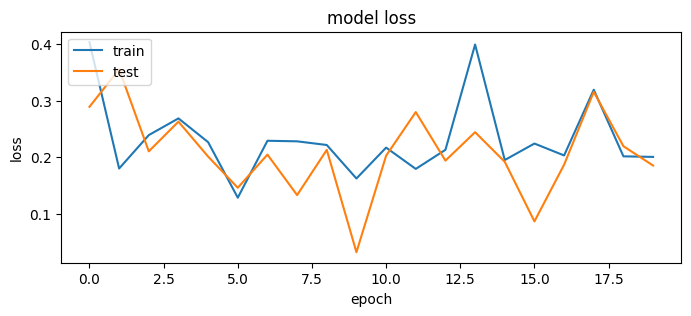

In [ ]:
# Summarize history for loss
plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

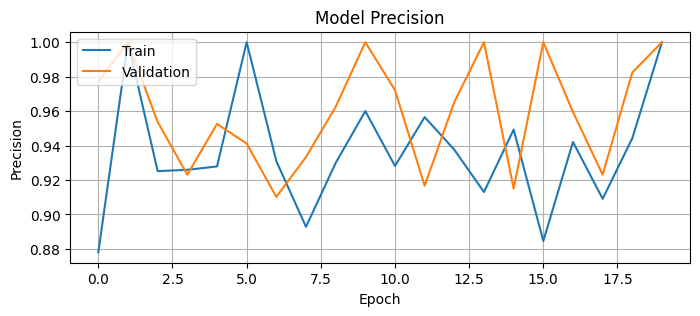

In [ ]:
# Summarize history for Precision
plt.figure(figsize=(8, 3))
plt.plot(history.history['precision_17'])
plt.plot(history.history['val_precision_17'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()


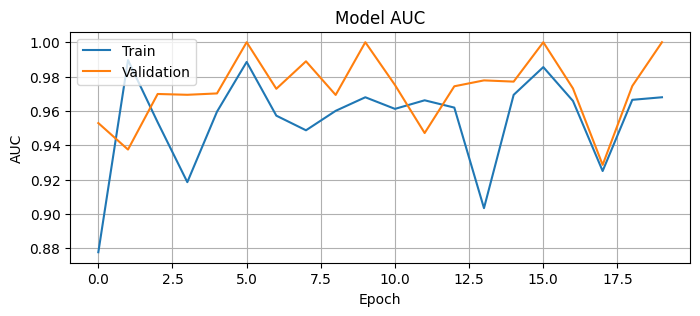

In [ ]:
# Summarize history for AUC
plt.figure(figsize=(8, 3))
plt.plot(history.history['auc_15'])
plt.plot(history.history['val_auc_15'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# Best Training
best_train_loss = min(history.history['loss'])
best_val_loss = min(history.history['val_loss'])
best_train_accuracy = max(history.history['accuracy'])
best_val_accuracy = max(history.history['val_accuracy'])
best_train_precision = max(history.history['precision_17'])
best_val_precision = max(history.history['val_precision_17'])
best_train_auc = max(history.history['auc_15'])
best_val_auc = max(history.history['val_auc_15'])

# Print the best performing metrics
print(f'Best Training Loss: {best_train_loss:.6f}')
print(f'Best Validation Loss: {best_val_loss:.6f}')
print(f'Best Training Accuracy: {best_train_accuracy:.6f}')
print(f'Best Validation Accuracy: {best_val_accuracy:.6f}')
print(f'Best Training Precision: {best_train_precision:.6f}')
print(f'Best Validation Precision: {best_val_precision:.6f}')
print(f'Best Training AUC: {best_train_auc:.6f}')
print(f'Best Validation AUC: {best_val_auc:.6f}')


Best Training Loss: 0.128776
Best Validation Loss: 0.032458
Best Training Accuracy: 0.968750
Best Validation Accuracy: 1.000000
Best Training Precision: 1.000000
Best Validation Precision: 1.000000
Best Training AUC: 0.989583
Best Validation AUC: 1.000000


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

TEST_DIR = '/kaggle/input/pediatric-pneumonia/test/'

# Get true labels from the directory structure
true_labels = []
for filename in test_generator.filenames:
    if 'NORMAL' in filename:
        true_labels.append(0)  # Normal
    else:
        true_labels.append(1)  # Pneumonia

true_labels = np.array(true_labels)

#predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step


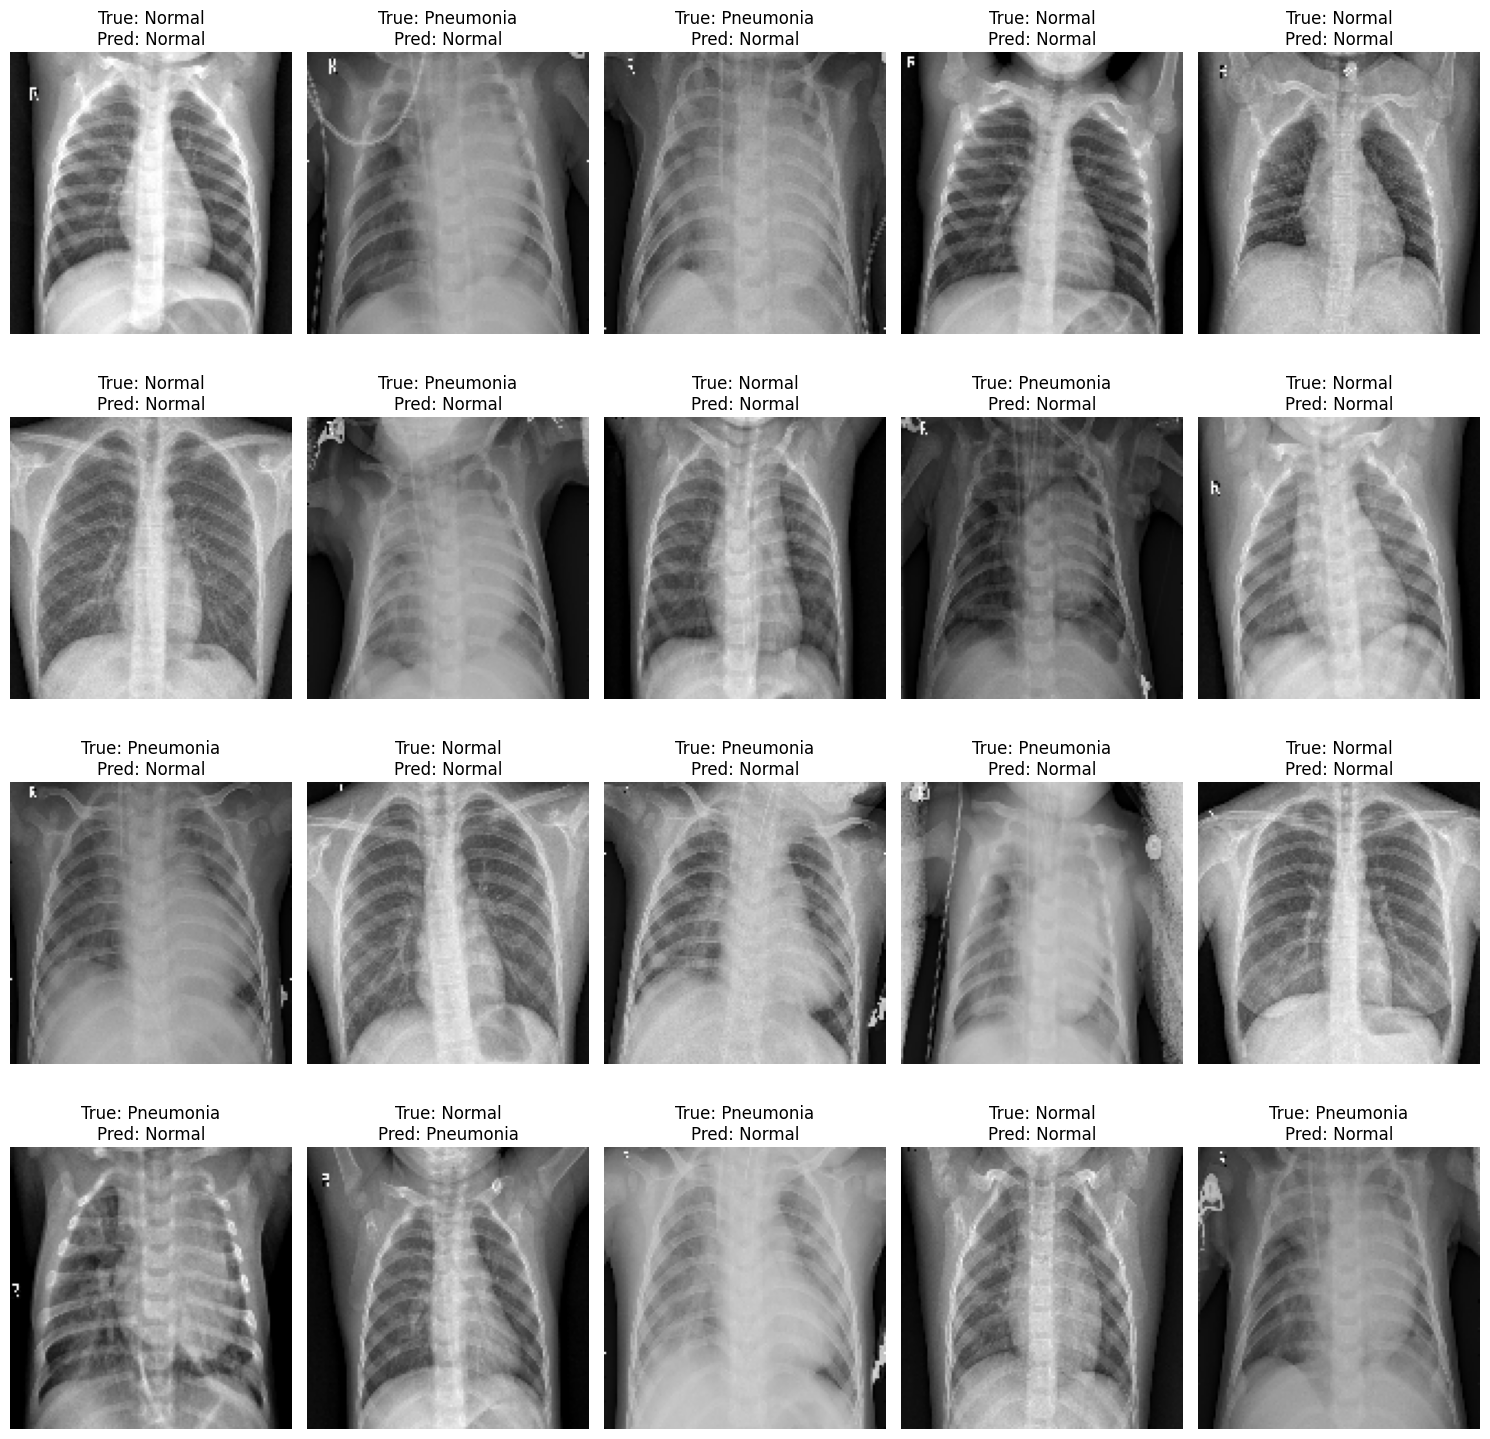

In [ ]:
#visualize some actual vs predicted
def visualize_predictions_grid(test_generator, predicted_classes, true_labels, num_images_per_class=10):
    #initialize images based on true labels
    normal_images = []
    pneumonia_images = []

    # Collect images based on their true labels
    for img_batch, label_batch in test_generator:
        for i in range(len(img_batch)):
            if label_batch[i] == 0 and len(normal_images) < num_images_per_class:
                normal_images.append((img_batch[i], 0))
            elif label_batch[i] == 1 and len(pneumonia_images) < num_images_per_class:
                pneumonia_images.append((img_batch[i], 1))

            # Stop collecting if reached required number of images
            if len(normal_images) >= num_images_per_class and len(pneumonia_images) >= num_images_per_class:
                break
        if len(normal_images) >= num_images_per_class and len(pneumonia_images) >= num_images_per_class:
            break

    # Combine and shuffle images
    images_to_display = normal_images + pneumonia_images
    np.random.shuffle(images_to_display)

    # Display images
    f, ax = plt.subplots(4, 5, figsize=(15, 15))
    for i in range(len(images_to_display)):
        img, true_label = images_to_display[i]
        true_label_text = 'Normal' if true_label == 0 else 'Pneumonia'
        predicted_label_text = 'Normal' if predicted_classes[i] == 0 else 'Pneumonia'

        ax[i // 5, i % 5].imshow(img)
        ax[i // 5, i % 5].set_title(f'True: {true_label_text}\nPred: {predicted_label_text}')
        ax[i // 5, i % 5].axis('off')

    plt.tight_layout()
    plt.show()
#visualize
visualize_predictions_grid(test_generator, predicted_classes, true_labels)


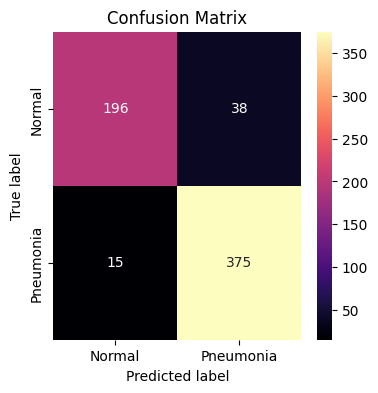

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

#true labels from the test generator
true_classes = test_generator.classes

#confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Calculate metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes)
auc = roc_auc_score(true_labels, predictions)  # Use predicted probabilities for AUC

#Print the metrics
print(f"TEST Accuracy: {accuracy:.6f}")
print(f"TEST Precision: {precision:.6f}")
print(f"TEST AUC: {auc:.6f}")


TEST Accuracy: 0.915064
TEST Precision: 0.907990
TEST AUC: 0.956246


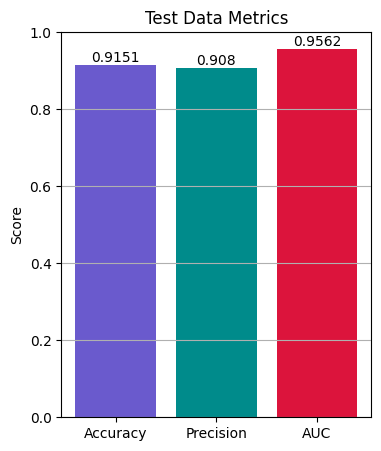

In [ ]:
#plot metrics

def plot_metrics(accuracy, precision, auc):
    metrics = ['Accuracy', 'Precision', 'AUC']
    values = [accuracy, precision, auc]

    plt.figure(figsize=(4, 5))
    bars = plt.bar(metrics, values, color=['slateblue', 'darkcyan', 'crimson'])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

    plt.ylim(0, 1)
    plt.title('Test Data Metrics')
    plt.ylabel('Score')
    plt.grid(axis='y')
    plt.show()

# visualize metrics
plot_metrics(accuracy, precision, auc)